# Bivariate Choropleth Mapping

## Final Project for GIS322 Spatial Data Structure by Quan Zhou

### 1, Background:
#### When cartographers trying to designe a choropleth map, they always want to display each attribute accurately and appropriately in terms of spatial distribution. To maximize the effeciency and minimized the confusion of map readers' interpretation, we need to present more than one attribution in mapping. Colors ara one of the most easy and common way to symbolize the attributes values in cartography. Colors' hue, brightness and saturation can be easily read and interpreted in mapping. In Bivariate Choropleth Mapping Project, I am trying to help catographers to better design and display two attributes in same choropleth map by combine two hues of colors, which seperately represent two kinds of attributions.
### 2, Goal:
#### a, Loading polygon data sources with ID number and more than 2 attributes; 
#### b, Define classifiers for two attributes; 
#### c, Generat appropriate bivariate size and color based legend; 
#### d, Visualizing map in browser and saving to HTML graphics files; User can chose the shapefile, attributes and color ramps.

### 3, Code:

In [22]:
%matplotlib inline
import pysal as ps
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats

## Classification

In [23]:
class Classifications:
    #
    # __author__ = "Quan Zhou"
    # __all__ = ['quantiles','equal_interval','natural_breaks','mean_standard_deviation']
    # To define 4 different classification methods and judge the user's choice.
    #
    def __init__(self, shape_name, attribute, k):
        #
        # shape_name: string-->the name of shapefile(***.shp)
        # attribute: string-->the title of attribute in this shapefile
        # k: int--> the number of classes of classification(usually k>2 and k<7)
        # df: panda data frame--> the data frame read from shapefile
        # data: list --> attribute values
        # 
        df = ps.pdio.read_files(ps.examples.get_path(shape_name))
        self.df = df
        self.attribute = attribute
        self.shape_name = shape_name
        self.data = [i[0] for i in df[[attribute]].values.tolist()]
        self.k = k
    
    def quantiles(self):
        #
        # Use Quantiles classification method to classify the attribute values.
        # return: np.array--> the upper boundaries of each class
        #
        w = 100. / self.k 
        #the percentage of each class
        p = np.arange(w, 100 + w, w)
        # assign the values in to their classes by percentage
        if p[-1] > 100.0:
            p[-1] = 100.0
        # define the upper boundary no greater than maximum value in data
        q = np.array([stats.scoreatpercentile(self.data, pct) for pct in p])
        return np.unique(q)

    def equal_interval(self):
        #
        # Use Equal Interval classification method to classify the attribute values.
        # return: np.array--> the upper boundaries of each class
        #
        mi = min(self.data)
        ma = max(self.data)
        width = (ma - mi)/ float(self.k)
        # define the width of each class
        cuts = np.arange(mi+width, ma + width, width)
        if len(cuts) > self.k:
            cuts = cuts[0:self.k]
        # assign values into different class
        cuts[-1] = ma
        # make sure the upper boundary is not greater than max of values
        q = cuts.copy()
        return np.unique(q)
    
    def natural_breaks(self):
        #
        # Use Natural Breaks classification method to classify the attribute values.
        # return: np.array--> the upper boundaries of each class
        #
        classifications = ps.Natural_Breaks(self.data, self.k)
        bins = classifications.bins
        
        return np.array(bins)
    
    def judge(self, cla_method):
        #
        # Judge the users' choice and call the responding function above.
        # return: list--> the classes ID for each row in attribute table
        #
        claR = []
        if cla_method == 'QT':
            claR = self.quantiles()
        if cla_method == 'EI':
            claR = self.equal_interval()
        if cla_method == 'NB':
            claR = self.natural_breaks()

        # calculate the classes ID for each row in attribute table
        class_N = []
        for i, data in enumerate(self.data):
            for k, clas in enumerate(claR):
                if (data <= clas and k == 0) or (data <= clas and data > claR[k-1]):
                    c = k
                    class_N.append(c)
                else: continue
        return class_N

## Plotting

In [24]:
import matplotlib.patches as patches
import matplotlib.colors as mpc
import matplotlib.colors as colors
from pysal.contrib.viz.color import get_color_map
import struct

In [25]:
from itertools import groupby
class Plotting (Classifications):
    def __init__(self, shape_name, cla_method, attribute, k):
        #
        # shape_name: string-->the name of shapefile(***.shp)
        # attribute: string-->the title of attribute in this shapefile
        # k: int--> the number of classes of classification(usually k>2 and k<7)
        # df: panda data frame--> the data frame read from shapefile
        # data: list --> attribute values
        # clalines: array--> the upper boundaries of each class
        # 
        # judge the user selected classification method
        Classifications.__init__(self, shape_name, attribute, k)
        if cla_method == 'QT':
            self.clalines = Classifications.quantiles(self)
        if cla_method == 'EI':
            self.clalines = Classifications.equal_interval(self)
        if cla_method == 'NB':
            self.clalines = Classifications.natural_breaks(self)
        self.cla_method = cla_method
        
    def distribution(self,color,colors):
        #
        # draw the data distribution plot(two subplots) to show the general distribution of selected attribute
        # cla_method: string-->'QT' for Quantile; 'EI' for Equal Intercal; 'NB' for Natural Break; 'MSD' for Mean Standard Deviation;
        # clor: string--> for color filled in ths distribution plot
        # colors: string --> for color ramp filled in the classes barchart
        #   
        # use seaborn package to generate the distribution plot
        # define the better looking plot style
        sns.set(palette="muted", color_codes=True)
        sns.set_style("ticks", {"xtick.major.size": 2, "ytick.major.size": 2})
        c = self.clalines.tolist()
        c.append(min(self.data))
        
        # In the first plot, disply the classes boundaries and totall distribution
        plt.subplot(2,1,1)
        for i in c:
            plt.axvline(x=i,color = color)
        fig = sns.distplot(self.data, hist=False,rug=True,kde_kws={"shade": True},color=color)
        # In ths second plot, display the count of data in each class:
        plt.subplot(2,1,2)
        a = Classifications.judge(self, self.cla_method)
        a.sort()
        field = [len(list(group)) for key, group in groupby(a)]
        print(field)
        x=self.k
        y=field
        sns.set_context(rc={"figure.figsize": (8, 4)})
        nd = np.arange(x)
        width=1
        plt.xticks(nd+width/2., ('First','Second','Third','Fourth','Fifth', 'Sixth','Seveth','Eighth','Nineth'))
        plt.xlim(-0.5,self.k+0.5)
        fig = plt.bar(nd, y, color=sns.color_palette(colors,self.k))
        plt.legend(fig, [self.attribute], loc = "upper right", title = self.shape_name)
        plt.show()
        
    def legend(self,color1,color2,attribute2):
        #
        # Generate the two dimensional legend with two color hues combined in k*k rigids
        # color1: string-->color ramp for attribute1
        # color2: string-->color ramp for attribute2
        # return: np.array--> array of color each of rigid
        #
        # get two color ramps selected by user
        a = np.array(get_color_map(name = color1,color_encoding='rgb',k=self.k))
        b = np.array(get_color_map(name= color2,color_encoding='rgb',k=self.k))
        # generate the two dimensional legend
        legend = []
        for con2, belt in enumerate(b):
            cls = []
            # combine the two selected hues of color in RGB
            for con1, hue in enumerate(a):
                rgb = (belt + hue)/2
                c = '#' + struct.pack('BBB',*rgb).encode('hex')
                cls.append(c)
            legend.append(cls)
        # draw the figure to show the colors in the legend
        fig = plt.figure(figsize=(3, 3))
        fig.suptitle('Legend', fontsize=14, fontweight='bold')
        w = h = 1/float(self.k)
        ax = fig.add_subplot(111, aspect='equal')
        ax.set_xlabel(self.attribute)
        ax.set_ylabel(attribute2)
        # set the lables and class boundaries
        for i, cmap in enumerate(legend):
            for j, clr in enumerate(cmap):
                c = mpc.hex2color(clr)
                x = i/float(self.k)
                y = j/float(self.k)
                p = patches.Rectangle((x,y), w, h, fill=True, color=c)
                ax.add_patch(p)
                plt.setp(ax.get_xticklabels(),visible=False)
                plt.setp(ax.get_yticklabels(),visible=False)
                plt.savefig('Legend', dpi = 80)

        return legend

## Choropleth Mapping

In [26]:
import geopandas as gpd
from bokeh.plotting import figure, output_file, show

In [27]:
def choroplethmap(shape_name,class1,class2,legend):
    #
    # shape_name: string-->the name of shapefile(***.shp)
    # class1: list--> the result of classification for each row of attribute1
    # class1: list--> the result of classification for each row of attribute1
    # legend: array--> the result of generated two dimensional legend
    #
    df = gpd.read_file(ps.examples.get_path(shape_name))
    nan = float('nan')
    lons = []
    lats = []
    # get the coordinates of each point in every polygon
    for i,shape in enumerate(df.geometry.values):
        # to read the polygons with islands or/and holes
        if shape.geom_type == 'MultiPolygon':
            gx = []
            gy = []
            ng = len(shape.geoms) - 1
            for j,member in enumerate(shape.geoms):
                xy = np.array(list(member.exterior.coords))
                xs = xy[:,0].tolist()
                ys = xy[:,1].tolist()
                gx.extend(xs)
                gy.extend(ys)
                if j < ng:
                    gx.append(nan)
                    gy.append(nan)
            lons.append(gx)
            lats.append(gy)
        # to read the polygons without holes or islands
        else:     
            xy = np.array(list(shape.exterior.coords))
            xs = xy[:,0].tolist()
            ys = xy[:,1].tolist()
            lons.append(xs)
            lats.append(ys) 
    # call the colors defined in legend by their classification ID
    colors = []
    for i in range(len(legend)):
        for j, color1 in enumerate(class1):
            if color1 == i:
                color2 = class2[j]
                colors.append(legend[color1][color2])
                
    # generate the choropleth map and output in the browser
    p = figure(title="Texas", toolbar_location='left',
              plot_width=1100, plot_height=700)
    p.patches(lons,lats, fill_alpha=0.7, fill_color=colors,
             line_color="#884444", line_width=2, line_alpha=0.3)
    output_file('choropleth.html', title="choropleth.py example")
    show(p)

### 4, Data Display

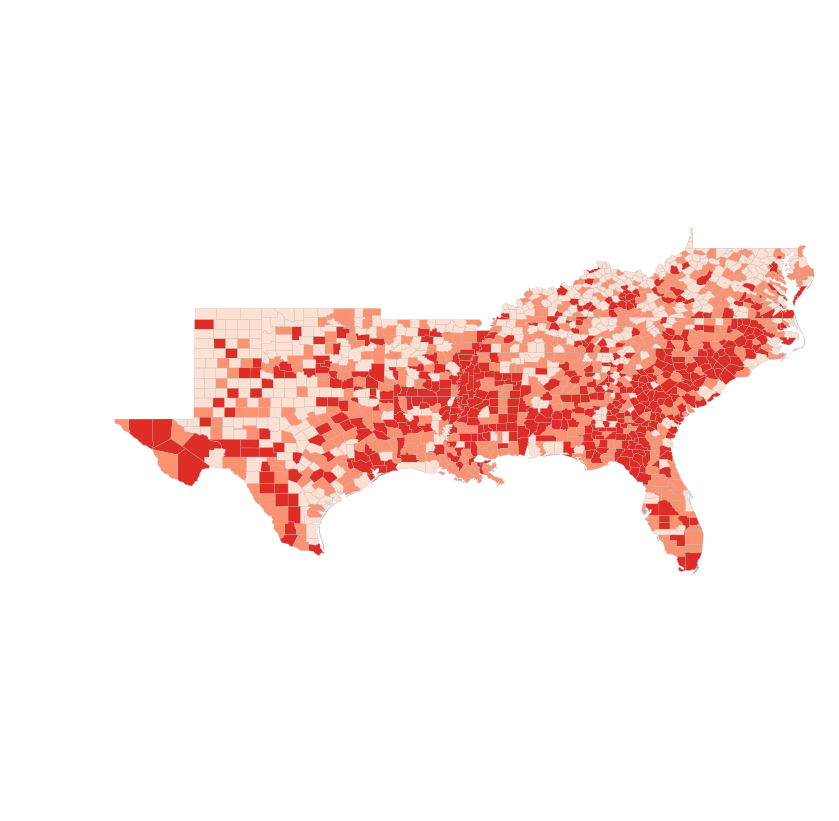

In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mpc

from ipywidgets import Dropdown, RadioButtons,  HBox, interact
from IPython.display import display
from pysal.contrib.viz import mapping as maps
from pysal.contrib.viz.color import get_maps_by_type
from pysal.contrib.viz.color import qualitative, sequential, diverging
from pysal.contrib.viz.color import get_color_map


ctypes = (sequential, diverging, qualitative)
color_display_types = {}
for ctype in ctypes:
    cmaps = get_maps_by_type(ctype)
    ctype_name = ctype.__name__.split(".")[-1]
    displays = {}
    for cmap in cmaps:
        cmap = cmap.split("_")[0]
        if cmap not in displays:
            c = get_color_map(cmtype=ctype_name, name=cmap)
            displays[cmap] = c
    color_display_types[ctype_name] = displays
    
def pcmaps(dtype,selected = 0):
    """
    Embed a figure displaying color maps for a given data type and mimic a
    selector
    """

    fig = plt.figure(figsize=(2, 2))
    w = 1. / (9 + .5 * (9-1))
    h = 1./11
    ax = fig.add_subplot(111, aspect='equal')
    for i, cmap in enumerate(color_display_types[dtype]):
        c = [mpc.hex2color(c) for c in color_display_types[dtype][cmap]]
        row = i / 9
        col = i % 9
        lx = col * (w + .5 * w)
        ly = (1-row) * (5 * h + h)
        for j, clr in enumerate(c):
            p = patches.Rectangle((lx, ly+(j*h)), w, h, fill=True, color=clr)
            ax.add_patch(p)
    
def choro(gd, col, show_cmaps=True, fig_size=(10, 10)):
    dt = sorted(color_display_types.keys(), reverse=True)
    data_type = RadioButtons(description='Data Type', options=dt)
    bindings = {}
    for t in dt:
        bindings[t] = color_display_types[t].keys()

    cmap_dd = Dropdown(description='CMap:', options=bindings[data_type.value])

    def type_change(change):
        with cmap_dd.hold_trait_notifications():
            cmap_dd.options = bindings[change['new']]
            k_dd.options = kbindings[change['new']]

    def cmap_change(change):
            with cmap_dd.hold_trait_notifications():
                print('new cmap', str(change['new']))

    data_type.observe(type_change, names=['value'])
    cmap_dd.observe(cmap_change, names=['value'])
    kbindings = {'sequential': map(str, range(3, 9+1)),
                 'qualitative': map(str, range(3, 12+1)),
                 'diverging': map(str, range(3, 11+1))}

    k_dd = Dropdown(description='k', options=kbindings[data_type.value])
    display(HBox([data_type, k_dd]))

    @interact(cmap=cmap_dd)
    def plot_cmaps(cmap):
        i = cmap_dd.options.index(cmap)
        #if show_cmaps:
            #pcmaps(data_type.value, i)
        maps.geoplot(gd, col, k=int(k_dd.value), palette=str(cmap_dd.value),
                     figsize=fig_size)
        
import pysal as ps
gd = ps.pdio.read_files(ps.examples.get_path('south.shp'))
choro(gd, 'HR90')

## 5, Example

In [29]:
c = Classifications('south.shp', 'HR90', 5)
classification = c.judge('NB')
classification.sort()
np.unique(classification)

array([0, 1, 2, 3, 4])

In [30]:
c2 = Classifications('south.dbf', 'BLK90', 5)
classification2 = c2.judge('NB')
classification2.sort()
np.unique(classification2)

array([0, 1, 2, 3, 4])

[580, 281, 227, 227, 97]


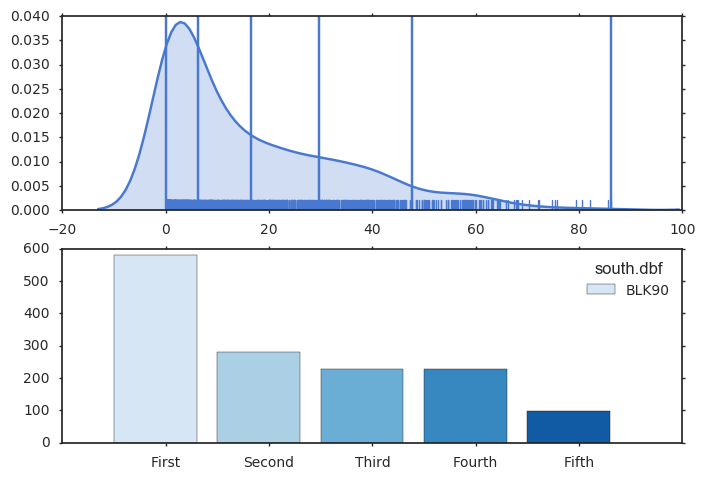

In [31]:
p1 = Plotting(shape_name = 'south.dbf', cla_method = 'NB', attribute ='BLK90', k=5)
p1.distribution('b','Blues')

[230, 427, 369, 265, 121]


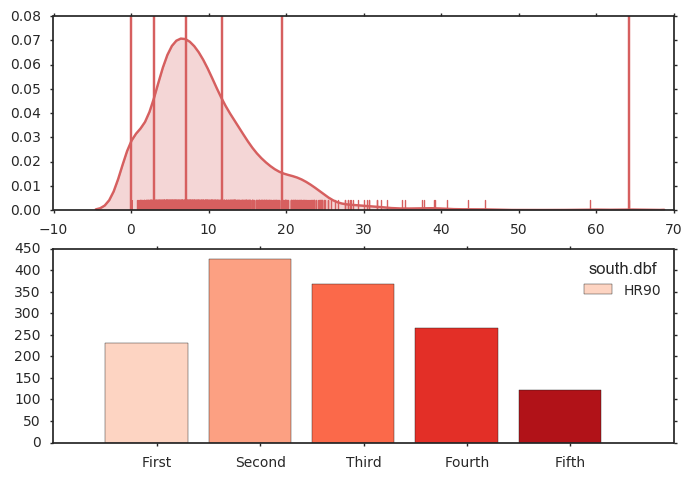

In [13]:
p2 = Plotting(shape_name = 'south.dbf', cla_method = 'NB', attribute ='HR90', k=5)
p2.distribution('r','Reds')

[['#bc8ebb', '#bb73a6', '#b94d9a', '#a0268f', '#7a1985'],
 ['#e0c8d8', '#deacc4', '#dc86b8', '#c360ac', '#9e53a3'],
 ['#faf1ec', '#f9d5d8', '#f7afcc', '#de89c0', '#b87cb7'],
 ['#d2e3c1', '#d0c7ac', '#cea1a0', '#b57b95', '#906e8b'],
 ['#7fb98c', '#7d9e78', '#7b786c', '#625160', '#3d4457']]

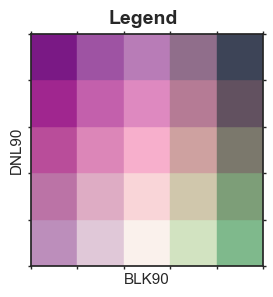

In [15]:
ld = p1.legend('RdPu','PRGn',attribute2 = 'DNL90')
ld

In [16]:
choroplethmap('south.shp',classification,classification2,ld)